# CGANs - Conditional Generative Adversarial Nets

Brief introduction to Conditional Generative Adversarial Nets or CGANs. This notebook is organized as follows:

1. **Research Paper**
* **Background**
* **Definition**
* **Training CGANs with Cifar-10 dataset, Keras and TensorFlow**


## 1. Research Paper

* [Conditional Generative Adversarial Nets](https://arxiv.org/pdf/1411.1784.pdf)

## 2. Background

**Generative adversarial nets** consists of two models: a generative model $G$ that captures the data distribution, and a discriminative model $D$ that estimates the probability that a sample came from the training data rather than $G$.

The generator distribution $p_g$ over data data $x$, the generator builds a mapping function from a prior noise distribution $p_z(z)$ to data space as $G(z;\theta_g)$.

The discriminator, $D(x;\theta_d)$, outputs a single scalar representing the probability that $x$ came form training data rather than $p_g$.

The **value function** $V(G,D)$:

$$ \underset{G}{min} \: \underset{D}{max} \; V_{GAN}(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z)))]$$

## 3. Definition

Generative adversarial nets can be extended to a **conditional model** if both the generator and discriminator are conditioned on some extra information $y$. 

* $y$ could be any kind of auxiliary information, such as class labels or data from other modalities. 

We can perform the conditioning by feeding $y$ into the both the discriminator and generator as additional input layer.

* **Generator**: The prior input noise $p_z(z)$, and $y$ are combined in joint hidden representation, and the adversarial training framework allows for considerable flexibility in how this hidden representation is composed.

* **Discriminator**: $x$ and $y$ are presented as inputs and to a discriminative function.

### Network Design

<img src="../../img/network_design_ccgan_cifar.png" width="600"> 


### Cost Funcion

$$ \underset{G}{min} \: \underset{D}{max} \; V_{CGAN}(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x|y)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z|y)))]$$

## 3. Training CGANs with CIFAR-10 dataset, Keras and TensorFlow

A CGANs implementation using the transposed convolution and convolution neural network, concatenate layers and the [Keras](https://keras.io/) library.

* **Data**
    * Rescale the Cifar-10 images to be between -1 and 1.
    
* **Generator**
    * Use the **inverse of convolution**, called transposed convolution.
    * **LeakyReLU activation** and **BatchNormalization**.
    * The input to the generator are the **normal distribution** $z$ and $𝑦$. They are combined in joint hidden representation.
        * Concatenate($y, z$).
    * The last activation is **tanh**.
    
* **Discriminator**
    * Use the **Convolutional neural network**.
    * **LeakyReLU activation**.
    * The input to the discriminator are $x$ and $y$. They are combined in joint hidden representation.
        *  Concatenate($y, x$).
    * The last activation is **sigmoid**.
    
* **Loss**
    * binary_crossentropy

* **Optimizer**
    * Adam(lr=0.0002, beta_1=0.5)

* batch_size = 64
* epochs = 100


### 1. Load data

#### Load libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


2023-11-08 08:36:20.584047: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-08 08:36:20.616584: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


#### Getting the data

In [2]:
# load dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()


#### Explore visual data

The CIFAR-10 images are RGB with 10 classes

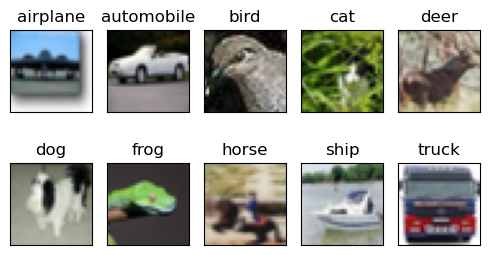

In [3]:
WIDTH_SIZE = 5
HEIGHT_SIZE = 3

num_classes = len(np.unique(y_train))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(WIDTH_SIZE, HEIGHT_SIZE))
for i in range(num_classes):
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = X_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    img = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(img)
    
plt.tight_layout()


#### Reshaping and normalizing the inputs

In [4]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')


X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [5]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32)
    X_test = X_test.reshape(X_test.shape[0], 3, 32, 32)
    input_shape = (3, 32, 32)
else:
    X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
    X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
    input_shape = (32, 32, 3)
    
# convert class vectors to binary class matrices
Y_train = tf.keras.utils.to_categorical(y_train, num_classes)
Y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

X_test = np.float32(X_test)
X_test = (X_test / 255 - 0.5) * 2
X_test = np.clip(X_test, -1, 1)

print('X_train reshape:', X_train.shape)
print('X_test reshape:', X_test.shape)


X_train reshape: (50000, 32, 32, 3)
X_test reshape: (10000, 32, 32, 3)


In [6]:
print(X_train[0].shape)


(32, 32, 3)


### 2. Define model

#### Generator

In [7]:
# latent space dimension
z = tf.keras.layers.Input(shape=(100,))

# classes
labels = tf.keras.layers.Input(shape=(10,))

# Generator network
merged_layer = tf.keras.layers.Concatenate()([z, labels])

generator = tf.keras.layers.Dense(2 * 2 * 512)(merged_layer)
generator = tf.keras.layers.BatchNormalization()(generator)
generator = tf.keras.layers.LeakyReLU()(generator)
generator = tf.keras.layers.Reshape((2, 2, 512))(generator)

generator = tf.keras.layers.Conv2DTranspose(
    256, kernel_size=5, strides=2, padding="same", use_bias=False
)(generator)
generator = tf.keras.layers.BatchNormalization()(generator)
generator = tf.keras.layers.LeakyReLU()(generator)

generator = tf.keras.layers.Conv2DTranspose(
    128, kernel_size=5, strides=2, padding="same", use_bias=False
)(generator)
generator = tf.keras.layers.BatchNormalization()(generator)
generator = tf.keras.layers.LeakyReLU()(generator)

generator = tf.keras.layers.Conv2DTranspose(
    64, kernel_size=5, strides=2, padding="same", use_bias=False
)(generator)
generator = tf.keras.layers.BatchNormalization()(generator)
generator = tf.keras.layers.LeakyReLU()(generator)

generator = tf.keras.layers.Conv2DTranspose(
    3,
    kernel_size=5,
    strides=2,
    padding="same",
    use_bias=False,
    activation="tanh",
)(generator)

generator = tf.keras.models.Model(
    inputs=[z, labels], outputs=generator, name="generator"
)


2023-11-08 08:36:22.173592: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-08 08:36:22.188055: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-08 08:36:22.188166: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-08 08:36:22.188737: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the

#### Generator model visualization

In [8]:
# prints a summary representation of your model
generator.summary()


Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 110)          0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 2048)         227328      ['concatenate[0][0]']    

#### Discriminator

In [9]:
# input image
img_input = tf.keras.layers.Input(shape=(X_train[0].shape))

# Discriminator network
discriminator = tf.keras.layers.Conv2D(
    64, kernel_size=5, strides=2, padding="same"
)(img_input)
discriminator = tf.keras.layers.LeakyReLU()(discriminator)
discriminator = tf.keras.layers.Dropout(0.3)(discriminator)

discriminator = tf.keras.layers.Conv2D(
    128, kernel_size=5, strides=2, padding="same"
)(discriminator)
discriminator = tf.keras.layers.LeakyReLU()(discriminator)
discriminator = tf.keras.layers.Dropout(0.3)(discriminator)

discriminator = tf.keras.layers.Conv2D(
    256, kernel_size=5, strides=2, padding="same"
)(discriminator)
discriminator = tf.keras.layers.LeakyReLU()(discriminator)
discriminator = tf.keras.layers.Dropout(0.3)(discriminator)

discriminator = tf.keras.layers.Conv2D(
    512, kernel_size=5, strides=2, padding="same"
)(discriminator)
discriminator = tf.keras.layers.LeakyReLU()(discriminator)
discriminator = tf.keras.layers.Dropout(0.3)(discriminator)

discriminator = tf.keras.layers.Flatten()(discriminator)

merged_layer = tf.keras.layers.Concatenate()([discriminator, labels])
discriminator = tf.keras.layers.Dense(512, activation="relu")(merged_layer)

discriminator = tf.keras.layers.Dense(1, activation="sigmoid")(discriminator)

discriminator = tf.keras.models.Model(
    inputs=[img_input, labels], outputs=discriminator, name="discriminator"
)


#### Discriminator model visualization

In [10]:
# prints a summary representation of your model
discriminator.summary()


Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   4864        ['input_3[0][0]']                
                                                                                                  
 leaky_re_lu_4 (LeakyReLU)      (None, 16, 16, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 16, 16, 64)   0           ['leaky_re_lu_4[0][0]']          
                                                                                      

### 3. Compile model

#### Compile discriminator

In [11]:
# Optimizer
discriminator.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss="binary_crossentropy",
    metrics=["binary_accuracy"],
)



#### Combined network

In [12]:
discriminator.trainable = False

label = tf.keras.layers.Input(shape=(10,), name='label')
z = tf.keras.layers.Input(shape=(100,), name='z')

fake_img = generator([z, label])
validity = discriminator([fake_img, label])

d_g = tf.keras.models.Model([z, label], validity, name='adversarial')

d_g.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0004, beta_1=0.5),
    loss="binary_crossentropy",
    metrics=["binary_accuracy"],
)


In [13]:
# prints a summary representation of your model
d_g.summary()


Model: "adversarial"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 z (InputLayer)                 [(None, 100)]        0           []                               
                                                                                                  
 label (InputLayer)             [(None, 10)]         0           []                               
                                                                                                  
 generator (Functional)         (None, 32, 32, 3)    4542912     ['z[0][0]',                      
                                                                  'label[0][0]']                  
                                                                                                  
 discriminator (Functional)     (None, 1)            5361281     ['generator[0][0]',    

### 4. Fit model


2023-11-08 08:36:22.769624: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8800
2023-11-08 08:36:22.821557: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-08 08:36:22.822098: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-08 08:36:22.822105: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-11-08 08:36:22.822402: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-08 08:36:22.822423: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-11-08 08:36:22.956813: I tensorflow/stream_executor/cuda/c

epoch = 1/120, d_loss=0.626, g_loss=3.455                                                                                                                         
1/1 [==============================] - 0s 185ms/step


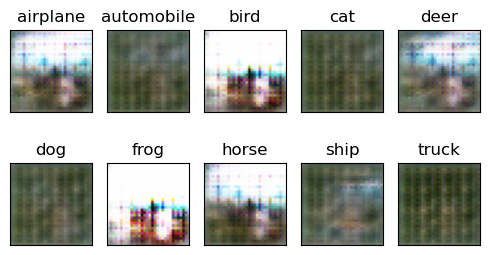

epoch = 2/120, d_loss=0.206, g_loss=4.502                                                                                                                         
epoch = 3/120, d_loss=0.182, g_loss=6.691                                                                                                                        
epoch = 4/120, d_loss=0.259, g_loss=3.344                                                                                                                        
epoch = 5/120, d_loss=0.229, g_loss=2.947                                                                                                                        
epoch = 6/120, d_loss=0.425, g_loss=3.224                                                                                                                        
epoch = 7/120, d_loss=0.332, g_loss=3.562                                                                                                                        
epoch = 8/120, d_loss=0.340

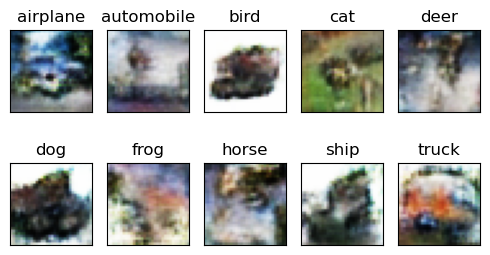

epoch = 12/120, d_loss=0.578, g_loss=2.415                                                                                                                        
epoch = 13/120, d_loss=0.452, g_loss=2.130                                                                                                                        
epoch = 14/120, d_loss=0.448, g_loss=2.350                                                                                                                        
epoch = 15/120, d_loss=0.478, g_loss=2.148                                                                                                                        
epoch = 16/120, d_loss=0.530, g_loss=2.040                                                                                                                        
epoch = 17/120, d_loss=0.468, g_loss=2.024                                                                                                                        
epoch = 18/120, d_loss

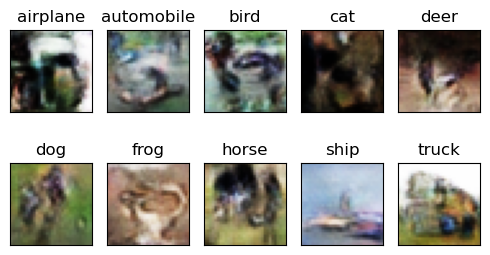

epoch = 22/120, d_loss=0.489, g_loss=2.247                                                                                                                        
epoch = 23/120, d_loss=0.483, g_loss=2.687                                                                                                                        
epoch = 24/120, d_loss=0.464, g_loss=2.072                                                                                                                        
epoch = 25/120, d_loss=0.424, g_loss=2.434                                                                                                                        
epoch = 26/120, d_loss=0.484, g_loss=1.909                                                                                                                        
epoch = 27/120, d_loss=0.456, g_loss=2.408                                                                                                                        
epoch = 28/120, d_loss

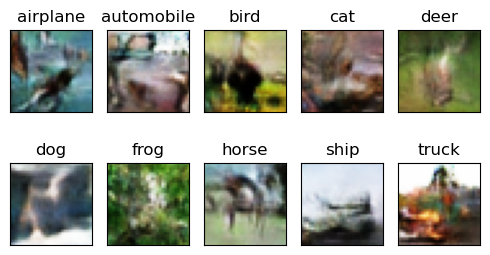

epoch = 32/120, d_loss=0.361, g_loss=2.491                                                                                                                        
epoch = 33/120, d_loss=0.428, g_loss=2.713                                                                                                                        
epoch = 34/120, d_loss=0.385, g_loss=2.189                                                                                                                        
epoch = 35/120, d_loss=0.373, g_loss=2.368                                                                                                                        
epoch = 36/120, d_loss=0.387, g_loss=2.507                                                                                                                        
epoch = 37/120, d_loss=0.462, g_loss=2.270                                                                                                                        
epoch = 38/120, d_loss

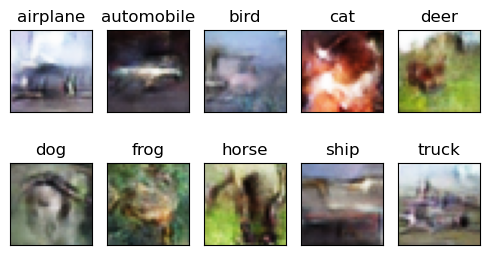

epoch = 42/120, d_loss=0.457, g_loss=2.250                                                                                                                        
epoch = 43/120, d_loss=0.338, g_loss=2.234                                                                                                                        
epoch = 44/120, d_loss=0.542, g_loss=2.707                                                                                                                        
epoch = 45/120, d_loss=0.394, g_loss=2.315                                                                                                                        
epoch = 46/120, d_loss=0.390, g_loss=2.564                                                                                                                        
epoch = 47/120, d_loss=0.391, g_loss=2.632                                                                                                                        
epoch = 48/120, d_loss

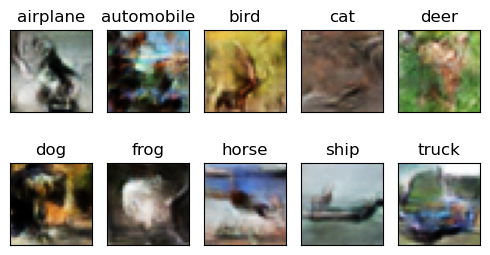

epoch = 52/120, d_loss=0.448, g_loss=2.808                                                                                                                        
epoch = 53/120, d_loss=0.375, g_loss=2.347                                                                                                                        
epoch = 54/120, d_loss=0.408, g_loss=2.789                                                                                                                        
epoch = 55/120, d_loss=0.383, g_loss=2.286                                                                                                                        
epoch = 56/120, d_loss=0.528, g_loss=1.960                                                                                                                        
epoch = 57/120, d_loss=0.417, g_loss=2.740                                                                                                                        
epoch = 58/120, d_loss

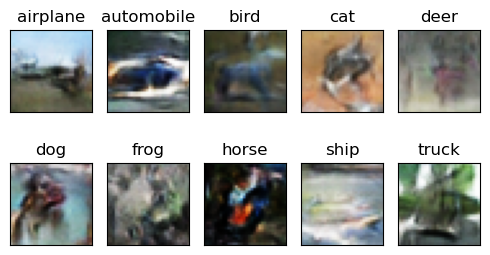

epoch = 62/120, d_loss=0.557, g_loss=2.580                                                                                                                        
epoch = 63/120, d_loss=0.447, g_loss=2.820                                                                                                                        
epoch = 64/120, d_loss=0.356, g_loss=2.503                                                                                                                        
epoch = 65/120, d_loss=0.506, g_loss=2.239                                                                                                                        
epoch = 66/120, d_loss=0.457, g_loss=2.256                                                                                                                        
epoch = 67/120, d_loss=0.481, g_loss=2.504                                                                                                                        
epoch = 68/120, d_loss

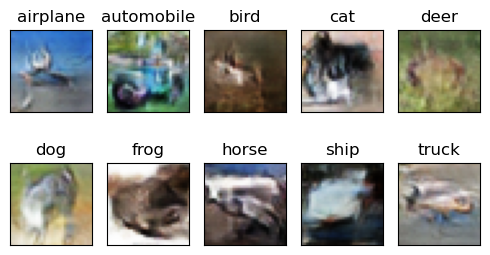

epoch = 72/120, d_loss=0.482, g_loss=2.129                                                                                                                        
epoch = 73/120, d_loss=0.437, g_loss=2.342                                                                                                                        
epoch = 74/120, d_loss=0.455, g_loss=3.185                                                                                                                        
epoch = 75/120, d_loss=0.449, g_loss=1.851                                                                                                                        
epoch = 76/120, d_loss=0.412, g_loss=2.957                                                                                                                        
epoch = 77/120, d_loss=0.386, g_loss=3.026                                                                                                                        
epoch = 78/120, d_loss

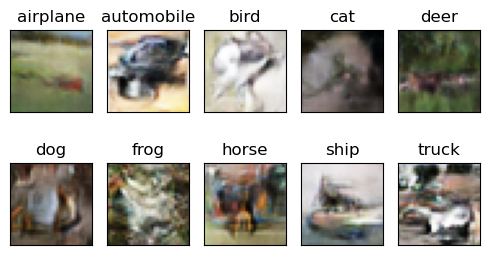

epoch = 82/120, d_loss=0.471, g_loss=2.723                                                                                                                        
epoch = 83/120, d_loss=0.517, g_loss=2.814                                                                                                                        
epoch = 84/120, d_loss=0.378, g_loss=3.113                                                                                                                        
epoch = 85/120, d_loss=0.333, g_loss=2.537                                                                                                                        
epoch = 86/120, d_loss=0.447, g_loss=2.605                                                                                                                        
epoch = 87/120, d_loss=0.421, g_loss=2.176                                                                                                                        
epoch = 88/120, d_loss

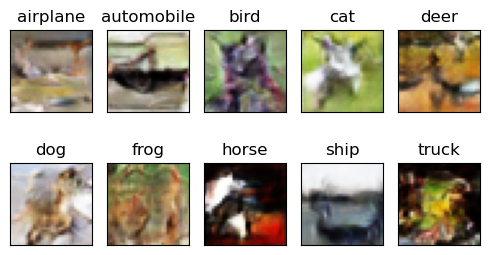

epoch = 92/120, d_loss=0.399, g_loss=2.563                                                                                                                        
epoch = 93/120, d_loss=0.364, g_loss=2.458                                                                                                                        
epoch = 94/120, d_loss=0.359, g_loss=3.067                                                                                                                        
epoch = 95/120, d_loss=0.314, g_loss=3.124                                                                                                                        
epoch = 96/120, d_loss=0.399, g_loss=2.501                                                                                                                        
epoch = 97/120, d_loss=0.351, g_loss=2.714                                                                                                                        
epoch = 98/120, d_loss

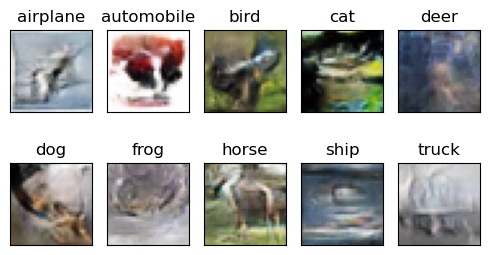

epoch = 102/120, d_loss=0.464, g_loss=3.246                                                                                                                        
epoch = 103/120, d_loss=0.609, g_loss=1.843                                                                                                                        
epoch = 104/120, d_loss=0.485, g_loss=2.517                                                                                                                        
epoch = 105/120, d_loss=0.471, g_loss=2.666                                                                                                                        
epoch = 106/120, d_loss=0.549, g_loss=2.419                                                                                                                        
epoch = 107/120, d_loss=0.417, g_loss=2.385                                                                                                                        
epoch = 108/120,

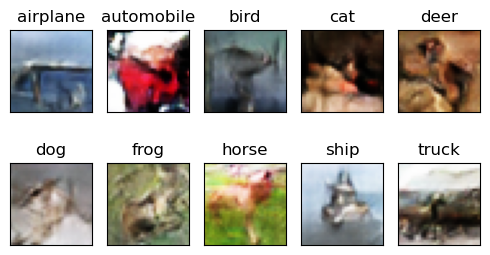

epoch = 112/120, d_loss=0.503, g_loss=2.237                                                                                                                        
epoch = 113/120, d_loss=0.450, g_loss=2.413                                                                                                                        
epoch = 114/120, d_loss=0.464, g_loss=2.671                                                                                                                        
epoch = 115/120, d_loss=0.356, g_loss=3.066                                                                                                                        
epoch = 116/120, d_loss=0.417, g_loss=2.638                                                                                                                        
epoch = 117/120, d_loss=0.434, g_loss=3.317                                                                                                                        
epoch = 118/120,

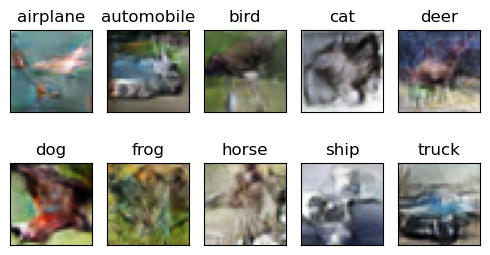

In [14]:
epochs = 120
batch_size = 32
smooth = 0.1
latent_dim = 100

real = tf.ones(shape=(batch_size, 1))
fake = tf.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):

        # Train Discriminator weights
        discriminator.trainable = True

        # Real samples
        X_batch = X_train[i * batch_size : (i + 1) * batch_size]
        real_labels = tf.keras.utils.to_categorical(
            y_train[i * batch_size : (i + 1) * batch_size].reshape(-1, 1),
            num_classes=10,
        )

        d_loss_real = discriminator.train_on_batch(
            x=[X_batch, real_labels], y=real * (1 - smooth)
        )

        # Fake Samples
        z = tf.random.normal(shape=(batch_size, latent_dim), mean=0, stddev=1)
        random_labels = tf.keras.utils.to_categorical(
            np.random.randint(0, 10, batch_size).reshape(-1, 1), num_classes=10
        )
        X_fake = generator.predict_on_batch([z, random_labels])

        d_loss_fake = discriminator.train_on_batch(
            x=[X_fake, random_labels], y=fake
        )

        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])

        # Train Generator weights
        discriminator.trainable = False

        z = tf.random.normal(shape=(batch_size, latent_dim), mean=0, stddev=1)
        random_labels = tf.keras.utils.to_categorical(
            np.random.randint(0, 10, batch_size).reshape(-1, 1), num_classes=10
        )
        d_g_loss_batch = d_g.train_on_batch(x=[z, random_labels], y=real)

        print(
            "epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f"
            % (
                e + 1,
                epochs,
                i,
                len(X_train) // batch_size,
                d_loss_batch,
                d_g_loss_batch[0],
            ),
            100 * " ",
            end="\r",
        )

    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])

    print(
        "epoch = %d/%d, d_loss=%.3f, g_loss=%.3f"
        % (e + 1, epochs, d_loss[-1], d_g_loss[-1]),
        100 * " ",
    )

    if e % 10 == 0:
        samples = 10
        z = tf.random.normal(shape=(samples, latent_dim), mean=0, stddev=1)
        labels = tf.keras.utils.to_categorical(
            np.arange(0, 10).reshape(-1, 1), num_classes=10
        )

        x_fake = generator.predict([z, labels])
        x_fake = np.clip(x_fake, -1, 1)
        x_fake = (x_fake + 1) * 127
        x_fake = np.round(x_fake).astype("uint8")

        fig = plt.figure(figsize=(WIDTH_SIZE, HEIGHT_SIZE))
        for k in range(samples):
            plt.subplot(2, 5, k + 1, xticks=[], yticks=[])
            plt.imshow(x_fake[k])
            plt.title(class_names[k])

        plt.tight_layout()
        plt.show()


### 5. Evaluate model

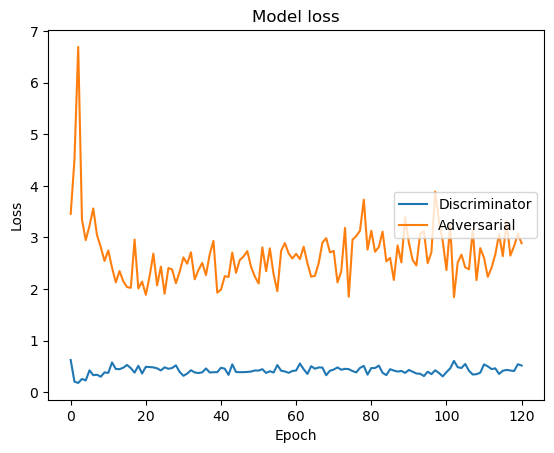

In [15]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()


## References

* [Conditional Generative Adversarial Nets](https://arxiv.org/pdf/1411.1784.pdf)
* [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)
* [The CIFAR-10 dataset](https://www.cs.toronto.edu/%7Ekriz/cifar.html)
* [Keras-GAN](https://github.com/eriklindernoren/Keras-GAN)